# MLP1L

In [1]:
import os
from PIL import Image
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

# --- Configuration ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_dir = r"Models and Data splits"
model_names = ["MLP1L_32", "MLP1L_64", "MLP1L_128", "MLP1L_256"]
parent_dir = r"adversarial_8bit_images"
BATCH_SIZE = 128 # You can adjust this based on your GPU memory and model size

# --- Custom Dataset for efficient loading ---
class ImageFolderDataset(Dataset):
    def __init__(self, folder_path):
        self.image_paths = []
        self.true_labels = []

        for fname in sorted(os.listdir(folder_path)):
            if not fname.lower().endswith(".png"):
                continue
            try:
                # Assuming format like "img_1_otherinfo.png"
                true_label = int(fname.split('_')[0][4:])
            except ValueError:
                continue # Skip files that don't match the expected naming
            except IndexError:
                continue # Skip files if split('_')[0] doesn't have enough characters

            self.image_paths.append(os.path.join(folder_path, fname))
            self.true_labels.append(true_label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        true_label = self.true_labels[idx]

        img = Image.open(img_path).convert("L") # Convert to grayscale
        arr = np.array(img, dtype=np.float32) / 255.0

        # Ensure image is 28x28. If not, resize.
        if arr.shape != (28, 28):
            img = img.resize((28, 28))
            arr = np.array(img, dtype=np.float32) / 255.0

        # Flatten the image for MLP input
        image_tensor = torch.from_numpy(arr.reshape(1, -1)) # Shape (1, 784)

        return image_tensor, torch.tensor(true_label, dtype=torch.long)


def evaluate_model_on_dataloader(model, dataloader):
    total_samples = 0
    misclassified_samples = 0

    with torch.no_grad():
        for inputs, true_labels in dataloader:
            inputs = inputs.squeeze(1).to(device) # Remove the single channel dimension (1, 784)
            true_labels = true_labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            total_samples += true_labels.size(0)
            misclassified_samples += (predicted != true_labels).sum().item()

    rate_pct = (misclassified_samples / total_samples * 100) if total_samples > 0 else 0.0
    return rate_pct

def print_table(title, folder_list, results):
    print(f"\n{title} Misclassification Rate Table:\n")
    print("{:<20}".format("Model"), end="")
    for folder in folder_list:
        print("{:>12}".format(folder), end="")
    print()
    # Separator line
    print("-" * 20, end="")
    for _ in folder_list:
        print("-" * 12, end="")
    print()

    for model_name in model_names:
        print("{:<20}".format(model_name), end="")
        for folder in folder_list:
            print("{:>12.2f}".format(results[model_name].get(folder, 0.0)), end="")
        print()

# --- Main Evaluation Logic ---

# 1. Get all folder names
all_folders = sorted([
    name for name in os.listdir(parent_dir)
    if os.path.isdir(os.path.join(parent_dir, name))
])

train_folders = [f for f in all_folders if f.endswith("_train")]
test_folders  = [f for f in all_folders if f.endswith("_test")]

# 2. Pre-load all data into DataLoader objects
# This ensures images are processed only once per folder, not per model
print("Loading image data (this may take a moment)...")
folder_dataloaders = {}
for folder_name in all_folders:
    folder_path = os.path.join(parent_dir, folder_name)
    dataset = ImageFolderDataset(folder_path)
    # Use num_workers > 0 for parallel data loading if on CPU, but be mindful of GPU if inputs are large.
    # For smaller images like 28x28, 0 or 1 might be fine.
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    folder_dataloaders[folder_name] = dataloader
print("Image data loaded.")

# 3. Evaluate models
results = {model_name: {} for model_name in model_names}

for model_name in model_names:
    print(f"\nEvaluating model: {model_name}...")
    model_path = os.path.join(model_dir, f"model_{model_name}.pt")
    model = torch.jit.load(model_path, map_location=device)
    model.eval() # Set model to evaluation mode (disables dropout, batchnorm updates, etc.)

    for folder_name, dataloader in folder_dataloaders.items():
        print(f"  Processing folder: {folder_name}")
        rate = evaluate_model_on_dataloader(model, dataloader)
        results[model_name][folder_name] = rate

# --- Print Results ---
print_table("Train", train_folders, results)
print_table("Test", test_folders, results)

Loading image data (this may take a moment)...
Image data loaded.

Evaluating model: MLP1L_32...
  Processing folder: CNNSca_test
  Processing folder: CNN_test
  Processing folder: CNN_train
  Processing folder: MLP1LSca_test
  Processing folder: MLP1L_128_test
  Processing folder: MLP1L_128_train
  Processing folder: MLP1L_256_test
  Processing folder: MLP1L_256_train
  Processing folder: MLP1L_32_test
  Processing folder: MLP1L_32_train
  Processing folder: MLP1L_64_test
  Processing folder: MLP1L_64_train
  Processing folder: MLP2L_128_test
  Processing folder: MLP2L_128_train
  Processing folder: MLP2L_256_test
  Processing folder: MLP2L_256_train
  Processing folder: MLP2L_32_test
  Processing folder: MLP2L_32_train
  Processing folder: MLP2L_64_test
  Processing folder: MLP2L_64_train
  Processing folder: RF_test
  Processing folder: RF_train
  Processing folder: SVM_test
  Processing folder: SVM_train
  Processing folder: XGB_test
  Processing folder: XGB_train
  Processing fold

In [31]:
import pandas as pd
import pyperclip

def create_table(folder_list, results):
    data = []
    for model_name in model_names:
        row = [results[model_name].get(folder, 0.0) for folder in folder_list]
        data.append(row)
    df = pd.DataFrame(data, index=model_names, columns=folder_list)
    return df

# Create train and test DataFrames
train_df = create_table(train_folders, results)
test_df = create_table(test_folders, results)

# Round to 2 decimals
train_df = train_df.round(2)
test_df = test_df.round(2)

# Convert to TSV (tab-separated values)
train_tsv = "Train Misclassification Rate Table:\n" + train_df.to_csv(sep="\t")
test_tsv  = "Test Misclassification Rate Table:\n" + test_df.to_csv(sep="\t")

# Combine and copy to clipboard
combined = train_tsv + "\n" + test_tsv
pyperclip.copy(combined)

print("✅ Tables copied to clipboard in spreadsheet-friendly format (TSV).")


✅ Tables copied to clipboard in spreadsheet-friendly format (TSV).


# MLP2L

In [33]:
import os
from PIL import Image
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

# --- Configuration ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_dir = r"Models and Data splits"
model_names = ["MLP2L_32", "MLP2L_64", "MLP2L_128", "MLP2L_256"]
parent_dir = r"adversarial_8bit_images"
BATCH_SIZE = 128 # You can adjust this based on your GPU memory and model size

# --- Custom Dataset for efficient loading ---
class ImageFolderDataset(Dataset):
    def __init__(self, folder_path):
        self.image_paths = []
        self.true_labels = []

        for fname in sorted(os.listdir(folder_path)):
            if not fname.lower().endswith(".png"):
                continue
            try:
                # Assuming format like "img_1_otherinfo.png"
                true_label = int(fname.split('_')[0][4:])
            except ValueError:
                continue # Skip files that don't match the expected naming
            except IndexError:
                continue # Skip files if split('_')[0] doesn't have enough characters

            self.image_paths.append(os.path.join(folder_path, fname))
            self.true_labels.append(true_label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        true_label = self.true_labels[idx]

        img = Image.open(img_path).convert("L") # Convert to grayscale
        arr = np.array(img, dtype=np.float32) / 255.0

        # Ensure image is 28x28. If not, resize.
        if arr.shape != (28, 28):
            img = img.resize((28, 28))
            arr = np.array(img, dtype=np.float32) / 255.0

        # Flatten the image for MLP input
        image_tensor = torch.from_numpy(arr.reshape(1, -1)) # Shape (1, 784)

        return image_tensor, torch.tensor(true_label, dtype=torch.long)


def evaluate_model_on_dataloader(model, dataloader):
    total_samples = 0
    misclassified_samples = 0

    with torch.no_grad():
        for inputs, true_labels in dataloader:
            inputs = inputs.squeeze(1).to(device) # Remove the single channel dimension (1, 784)
            true_labels = true_labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            total_samples += true_labels.size(0)
            misclassified_samples += (predicted != true_labels).sum().item()

    rate_pct = (misclassified_samples / total_samples * 100) if total_samples > 0 else 0.0
    return rate_pct

def print_table(title, folder_list, results):
    print(f"\n{title} Misclassification Rate Table:\n")
    print("{:<20}".format("Model"), end="")
    for folder in folder_list:
        print("{:>12}".format(folder), end="")
    print()
    # Separator line
    print("-" * 20, end="")
    for _ in folder_list:
        print("-" * 12, end="")
    print()

    for model_name in model_names:
        print("{:<20}".format(model_name), end="")
        for folder in folder_list:
            print("{:>12.2f}".format(results[model_name].get(folder, 0.0)), end="")
        print()

# --- Main Evaluation Logic ---

# 1. Get all folder names
all_folders = sorted([
    name for name in os.listdir(parent_dir)
    if os.path.isdir(os.path.join(parent_dir, name))
])

train_folders = [f for f in all_folders if f.endswith("_train")]
test_folders  = [f for f in all_folders if f.endswith("_test")]

# 2. Pre-load all data into DataLoader objects
# This ensures images are processed only once per folder, not per model
print("Loading image data (this may take a moment)...")
folder_dataloaders = {}
for folder_name in all_folders:
    folder_path = os.path.join(parent_dir, folder_name)
    dataset = ImageFolderDataset(folder_path)
    # Use num_workers > 0 for parallel data loading if on CPU, but be mindful of GPU if inputs are large.
    # For smaller images like 28x28, 0 or 1 might be fine.
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    folder_dataloaders[folder_name] = dataloader
print("Image data loaded.")

# 3. Evaluate models
results = {model_name: {} for model_name in model_names}

for model_name in model_names:
    print(f"\nEvaluating model: {model_name}...")
    model_path = os.path.join(model_dir, f"model_{model_name}.pt")
    model = torch.jit.load(model_path, map_location=device)
    model.eval() # Set model to evaluation mode (disables dropout, batchnorm updates, etc.)

    for folder_name, dataloader in folder_dataloaders.items():
        print(f"  Processing folder: {folder_name}")
        rate = evaluate_model_on_dataloader(model, dataloader)
        results[model_name][folder_name] = rate

# --- Print Results ---
print_table("Train", train_folders, results)
print_table("Test", test_folders, results)

Loading image data (this may take a moment)...
Image data loaded.

Evaluating model: MLP2L_32...
  Processing folder: CNNSca_test
  Processing folder: CNN_test
  Processing folder: CNN_train
  Processing folder: MLP1LSca_test
  Processing folder: MLP1L_128_test
  Processing folder: MLP1L_128_train
  Processing folder: MLP1L_256_test
  Processing folder: MLP1L_256_train
  Processing folder: MLP1L_32_test
  Processing folder: MLP1L_32_train
  Processing folder: MLP1L_64_test
  Processing folder: MLP1L_64_train
  Processing folder: MLP2L_128_test
  Processing folder: MLP2L_128_train
  Processing folder: MLP2L_256_test
  Processing folder: MLP2L_256_train
  Processing folder: MLP2L_32_test
  Processing folder: MLP2L_32_train
  Processing folder: MLP2L_64_test
  Processing folder: MLP2L_64_train
  Processing folder: RF_test
  Processing folder: RF_train
  Processing folder: SVM_test
  Processing folder: SVM_train
  Processing folder: XGB_test
  Processing folder: XGB_train
  Processing fold

In [35]:
import pandas as pd
import pyperclip

def create_table(folder_list, results):
    data = []
    for model_name in model_names:
        row = [results[model_name].get(folder, 0.0) for folder in folder_list]
        data.append(row)
    df = pd.DataFrame(data, index=model_names, columns=folder_list)
    return df

# Create train and test DataFrames
train_df = create_table(train_folders, results)
test_df = create_table(test_folders, results)

# Round to 2 decimals
train_df = train_df.round(2)
test_df = test_df.round(2)

# Convert to TSV (tab-separated values)
train_tsv = "Train Misclassification Rate Table:\n" + train_df.to_csv(sep="\t")
test_tsv  = "Test Misclassification Rate Table:\n" + test_df.to_csv(sep="\t")

# Combine and copy to clipboard
combined = train_tsv + "\n" + test_tsv
pyperclip.copy(combined)

print("✅ Tables copied to clipboard in spreadsheet-friendly format (TSV).")


✅ Tables copied to clipboard in spreadsheet-friendly format (TSV).


# CNN

In [37]:
import os
from PIL import Image
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

# --- Configuration ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_dir = r"Models and Data splits"
model_names = ["CNN"]  # Replace with your CNN model names if needed
parent_dir = r"adversarial_8bit_images"
BATCH_SIZE = 128  # You can adjust this based on your GPU memory and model size

# --- Custom Dataset for CNNs (expects 1x28x28 input) ---
class ImageFolderDataset(Dataset):
    def __init__(self, folder_path):
        self.image_paths = []
        self.true_labels = []

        for fname in sorted(os.listdir(folder_path)):
            if not fname.lower().endswith(".png"):
                continue
            try:
                true_label = int(fname.split('_')[0][4:])
            except (ValueError, IndexError):
                continue

            self.image_paths.append(os.path.join(folder_path, fname))
            self.true_labels.append(true_label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        true_label = self.true_labels[idx]

        img = Image.open(img_path).convert("L")  # Convert to grayscale
        arr = np.array(img, dtype=np.float32) / 255.0

        if arr.shape != (28, 28):
            img = img.resize((28, 28))
            arr = np.array(img, dtype=np.float32) / 255.0

        # For CNN: keep channel dimension as (1, 28, 28)
        image_tensor = torch.from_numpy(arr).unsqueeze(0)  # Add channel dimension

        return image_tensor, torch.tensor(true_label, dtype=torch.long)


def evaluate_model_on_dataloader(model, dataloader):
    total_samples = 0
    misclassified_samples = 0

    with torch.no_grad():
        for inputs, true_labels in dataloader:
            inputs = inputs.to(device)  # Shape: (batch, 1, 28, 28)
            true_labels = true_labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            total_samples += true_labels.size(0)
            misclassified_samples += (predicted != true_labels).sum().item()

    rate_pct = (misclassified_samples / total_samples * 100) if total_samples > 0 else 0.0
    return rate_pct


def print_table(title, folder_list, results):
    print(f"\n{title} Misclassification Rate Table:\n")
    print("{:<20}".format("Model"), end="")
    for folder in folder_list:
        print("{:>12}".format(folder), end="")
    print()
    print("-" * 20, end="")
    for _ in folder_list:
        print("-" * 12, end="")
    print()

    for model_name in model_names:
        print("{:<20}".format(model_name), end="")
        for folder in folder_list:
            print("{:>12.2f}".format(results[model_name].get(folder, 0.0)), end="")
        print()


# --- Main Evaluation Logic ---
# 1. Get all folder names
all_folders = sorted([
    name for name in os.listdir(parent_dir)
    if os.path.isdir(os.path.join(parent_dir, name))
])

train_folders = [f for f in all_folders if f.endswith("_train")]
test_folders  = [f for f in all_folders if f.endswith("_test")]

# 2. Pre-load all data into DataLoader objects
print("Loading image data (this may take a moment)...")
folder_dataloaders = {}
for folder_name in all_folders:
    folder_path = os.path.join(parent_dir, folder_name)
    dataset = ImageFolderDataset(folder_path)
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    folder_dataloaders[folder_name] = dataloader
print("Image data loaded.")

# 3. Evaluate models
results = {model_name: {} for model_name in model_names}

for model_name in model_names:
    print(f"\nEvaluating model: {model_name}...")
    model_path = os.path.join(model_dir, f"model_{model_name}.pt")
    model = torch.jit.load(model_path, map_location=device)
    model.eval()

    for folder_name, dataloader in folder_dataloaders.items():
        print(f"  Processing folder: {folder_name}")
        rate = evaluate_model_on_dataloader(model, dataloader)
        results[model_name][folder_name] = rate

# 4. Print results
print_table("Train", train_folders, results)
print_table("Test", test_folders, results)


Loading image data (this may take a moment)...
Image data loaded.

Evaluating model: CNN...
  Processing folder: CNNSca_test
  Processing folder: CNN_test
  Processing folder: CNN_train
  Processing folder: MLP1LSca_test
  Processing folder: MLP1L_128_test
  Processing folder: MLP1L_128_train
  Processing folder: MLP1L_256_test
  Processing folder: MLP1L_256_train
  Processing folder: MLP1L_32_test
  Processing folder: MLP1L_32_train
  Processing folder: MLP1L_64_test
  Processing folder: MLP1L_64_train
  Processing folder: MLP2L_128_test
  Processing folder: MLP2L_128_train
  Processing folder: MLP2L_256_test
  Processing folder: MLP2L_256_train
  Processing folder: MLP2L_32_test
  Processing folder: MLP2L_32_train
  Processing folder: MLP2L_64_test
  Processing folder: MLP2L_64_train
  Processing folder: RF_test
  Processing folder: RF_train
  Processing folder: SVM_test
  Processing folder: SVM_train
  Processing folder: XGB_test
  Processing folder: XGB_train
  Processing folder: k

In [39]:
import pandas as pd
import pyperclip

def create_table(folder_list, results):
    data = []
    for model_name in model_names:
        row = [results[model_name].get(folder, 0.0) for folder in folder_list]
        data.append(row)
    df = pd.DataFrame(data, index=model_names, columns=folder_list)
    return df

# Create train and test DataFrames
train_df = create_table(train_folders, results)
test_df = create_table(test_folders, results)

# Round to 2 decimals
train_df = train_df.round(2)
test_df = test_df.round(2)

# Convert to TSV (tab-separated values)
train_tsv = "Train Misclassification Rate Table:\n" + train_df.to_csv(sep="\t")
test_tsv  = "Test Misclassification Rate Table:\n" + test_df.to_csv(sep="\t")

# Combine and copy to clipboard
combined = train_tsv + "\n" + test_tsv
pyperclip.copy(combined)

print("✅ Tables copied to clipboard in spreadsheet-friendly format (TSV).")


✅ Tables copied to clipboard in spreadsheet-friendly format (TSV).


## Random Forests (RF)

In [44]:
import os
from PIL import Image
import numpy as np
import joblib
from torch.utils.data import Dataset, DataLoader

# --- Configuration ---
model_dir = r"Models and Data splits"
model_names = ["RF"]  # Replace with your RF model filenames
parent_dir = r"adversarial_8bit_images"
BATCH_SIZE = 128

# --- Custom Dataset for RF models (expects 1D flattened input) ---
class ImageFolderDataset(Dataset):
    def __init__(self, folder_path):
        self.image_paths = []
        self.true_labels = []

        for fname in sorted(os.listdir(folder_path)):
            if not fname.lower().endswith(".png"):
                continue
            try:
                true_label = int(fname.split('_')[0][4:])
            except (ValueError, IndexError):
                continue

            self.image_paths.append(os.path.join(folder_path, fname))
            self.true_labels.append(true_label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        true_label = self.true_labels[idx]

        img = Image.open(img_path).convert("L")  # Convert to grayscale
        arr = np.array(img, dtype=np.float32) / 255.0

        if arr.shape != (28, 28):
            img = img.resize((28, 28))
            arr = np.array(img, dtype=np.float32) / 255.0

        # Flatten for RF model: shape (784,)
        image_flat = arr.reshape(-1)

        return image_flat, true_label


def evaluate_model_on_dataloader(model, dataloader):
    total_samples = 0
    misclassified_samples = 0

    for inputs, true_labels in dataloader:
        inputs_np = inputs.numpy()  # Convert from Tensor to NumPy
        true_labels_np = np.array(true_labels)

        preds = model.predict(inputs_np)
        misclassified_samples += np.sum(preds != true_labels_np)
        total_samples += len(true_labels_np)

    rate_pct = (misclassified_samples / total_samples * 100) if total_samples > 0 else 0.0
    return rate_pct


def print_table(title, folder_list, results):
    print(f"\n{title} Misclassification Rate Table:\n")
    print("{:<20}".format("Model"), end="")
    for folder in folder_list:
        print("{:>12}".format(folder), end="")
    print()
    print("-" * 20, end="")
    for _ in folder_list:
        print("-" * 12, end="")
    print()

    for model_name in model_names:
        print("{:<20}".format(model_name), end="")
        for folder in folder_list:
            print("{:>12.2f}".format(results[model_name].get(folder, 0.0)), end="")
        print()


# --- Main Evaluation Logic ---
all_folders = sorted([
    name for name in os.listdir(parent_dir)
    if os.path.isdir(os.path.join(parent_dir, name))
])

train_folders = [f for f in all_folders if f.endswith("_train")]
test_folders  = [f for f in all_folders if f.endswith("_test")]

# 1. Pre-load DataLoaders
print("Loading image data (this may take a moment)...")
from torch.utils.data import DataLoader
folder_dataloaders = {}
for folder_name in all_folders:
    folder_path = os.path.join(parent_dir, folder_name)
    dataset = ImageFolderDataset(folder_path)
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    folder_dataloaders[folder_name] = dataloader
print("Image data loaded.")

# 2. Evaluate each RF model
results = {model_name: {} for model_name in model_names}

for model_name in model_names:
    print(f"\nEvaluating model: {model_name}...")
    model_path = os.path.join(model_dir, f"model_{model_name}.pkl")
    model = joblib.load(model_path)

    for folder_name, dataloader in folder_dataloaders.items():
        print(f"  Processing folder: {folder_name}")
        rate = evaluate_model_on_dataloader(model, dataloader)
        results[model_name][folder_name] = rate

# 3. Print results
print_table("Train", train_folders, results)
print_table("Test", test_folders, results)


Loading image data (this may take a moment)...
Image data loaded.

Evaluating model: RF...
  Processing folder: CNNSca_test
  Processing folder: CNN_test
  Processing folder: CNN_train
  Processing folder: MLP1LSca_test
  Processing folder: MLP1L_128_test
  Processing folder: MLP1L_128_train
  Processing folder: MLP1L_256_test
  Processing folder: MLP1L_256_train
  Processing folder: MLP1L_32_test
  Processing folder: MLP1L_32_train
  Processing folder: MLP1L_64_test
  Processing folder: MLP1L_64_train
  Processing folder: MLP2L_128_test
  Processing folder: MLP2L_128_train
  Processing folder: MLP2L_256_test
  Processing folder: MLP2L_256_train
  Processing folder: MLP2L_32_test
  Processing folder: MLP2L_32_train
  Processing folder: MLP2L_64_test
  Processing folder: MLP2L_64_train
  Processing folder: RF_test
  Processing folder: RF_train
  Processing folder: SVM_test
  Processing folder: SVM_train
  Processing folder: XGB_test
  Processing folder: XGB_train
  Processing folder: kN

In [51]:
import pandas as pd
import pyperclip

def create_table(folder_list, results):
    data = []
    for model_name in model_names:
        row = [results[model_name].get(folder, 0.0) for folder in folder_list]
        data.append(row)
    df = pd.DataFrame(data, index=model_names, columns=folder_list)
    return df

# Create train and test DataFrames
train_df = create_table(train_folders, results)
test_df = create_table(test_folders, results)

# Round to 2 decimals
train_df = train_df.round(2)
test_df = test_df.round(2)

# Convert to TSV (tab-separated values)
train_tsv = "Train Misclassification Rate Table:\n" + train_df.to_csv(sep="\t")
test_tsv  = "Test Misclassification Rate Table:\n" + test_df.to_csv(sep="\t")

# Combine and copy to clipboard
combined = train_tsv + "\n" + test_tsv
pyperclip.copy(combined)

print("✅ Tables copied to clipboard in spreadsheet-friendly format (TSV).")


✅ Tables copied to clipboard in spreadsheet-friendly format (TSV).


### SVM

In [63]:
import os
from PIL import Image
import numpy as np
from torch.utils.data import Dataset, DataLoader
import joblib

# --- Configuration ---
model_dir = r"Models and Data splits"
model_names = ["SVM"]
parent_dir = r"adversarial_8bit_images"
BATCH_SIZE = 128

# --- Custom Dataset for SVM (expects flattened NumPy arrays) ---
class ImageFolderDataset(Dataset):
    def __init__(self, folder_path):
        self.image_paths = []
        self.true_labels = []

        for fname in sorted(os.listdir(folder_path)):
            if not fname.lower().endswith(".png"):
                continue
            try:
                true_label = int(fname.split('_')[0][4:])
            except (ValueError, IndexError):
                continue

            self.image_paths.append(os.path.join(folder_path, fname))
            self.true_labels.append(true_label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        true_label = self.true_labels[idx]

        img = Image.open(img_path).convert("L")
        arr = np.array(img, dtype=np.float32) / 255.0

        if arr.shape != (28, 28):
            img = img.resize((28, 28))
            arr = np.array(img, dtype=np.float32) / 255.0

        image_flat = arr.reshape(-1)  # Shape (784,)
        return image_flat, true_label


def evaluate_model_on_dataloader(model, dataloader):
    total_samples = 0
    misclassified_samples = 0

    for inputs, true_labels in dataloader:
        inputs_np = inputs.numpy()
        true_labels_np = np.array(true_labels)

        preds = model.predict(inputs_np)
        misclassified_samples += np.sum(preds != true_labels_np)
        total_samples += len(true_labels_np)

    rate_pct = (misclassified_samples / total_samples * 100) if total_samples > 0 else 0.0
    return rate_pct


def print_table(title, folder_list, results):
    print(f"\n{title} Misclassification Rate Table:\n")
    print("{:<20}".format("Model"), end="")
    for folder in folder_list:
        print("{:>12}".format(folder), end="")
    print()
    print("-" * 20, end="")
    for _ in folder_list:
        print("-" * 12, end="")
    print()

    for model_name in model_names:
        print("{:<20}".format(model_name), end="")
        for folder in folder_list:
            print("{:>12.2f}".format(results[model_name].get(folder, 0.0)), end="")
        print()


# --- Main Evaluation Logic ---
all_folders = sorted([
    name for name in os.listdir(parent_dir)
    if os.path.isdir(os.path.join(parent_dir, name))
])

train_folders = [f for f in all_folders if f.endswith("_train")]
test_folders  = [f for f in all_folders if f.endswith("_test")]

# 1. Load datasets
print("Loading image data (this may take a moment)...")
folder_dataloaders = {}
for folder_name in all_folders:
    folder_path = os.path.join(parent_dir, folder_name)
    dataset = ImageFolderDataset(folder_path)
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    folder_dataloaders[folder_name] = dataloader
print("Image data loaded.")

# 2. Evaluate each SVM model
results = {model_name: {} for model_name in model_names}

for model_name in model_names:
    print(f"\nEvaluating model: {model_name}...")
    model_path = os.path.join(model_dir, f"model_{model_name}.pkl")
    model = joblib.load(model_path)

    for folder_name, dataloader in folder_dataloaders.items():
        print(f"  Processing folder: {folder_name}")
        rate = evaluate_model_on_dataloader(model, dataloader)
        results[model_name][folder_name] = rate

# 3. Print results
print_table("Train", train_folders, results)
print_table("Test", test_folders, results)


Loading image data (this may take a moment)...
Image data loaded.

Evaluating model: SVM...
  Processing folder: CNNSca_test
  Processing folder: CNN_test
  Processing folder: CNN_train
  Processing folder: MLP1LSca_test
  Processing folder: MLP1L_128_test
  Processing folder: MLP1L_128_train
  Processing folder: MLP1L_256_test
  Processing folder: MLP1L_256_train
  Processing folder: MLP1L_32_test
  Processing folder: MLP1L_32_train
  Processing folder: MLP1L_64_test
  Processing folder: MLP1L_64_train
  Processing folder: MLP2L_128_test
  Processing folder: MLP2L_128_train
  Processing folder: MLP2L_256_test
  Processing folder: MLP2L_256_train
  Processing folder: MLP2L_32_test
  Processing folder: MLP2L_32_train
  Processing folder: MLP2L_64_test
  Processing folder: MLP2L_64_train
  Processing folder: RF_test
  Processing folder: RF_train
  Processing folder: SVM_test
  Processing folder: SVM_train
  Processing folder: XGB_test
  Processing folder: XGB_train
  Processing folder: k

In [65]:
import pandas as pd
import pyperclip

def create_table(folder_list, results):
    data = []
    for model_name in model_names:
        row = [results[model_name].get(folder, 0.0) for folder in folder_list]
        data.append(row)
    df = pd.DataFrame(data, index=model_names, columns=folder_list)
    return df

# Create train and test DataFrames
train_df = create_table(train_folders, results)
test_df = create_table(test_folders, results)

# Round to 2 decimals
train_df = train_df.round(2)
test_df = test_df.round(2)

# Convert to TSV (tab-separated values)
train_tsv = "Train Misclassification Rate Table:\n" + train_df.to_csv(sep="\t")
test_tsv  = "Test Misclassification Rate Table:\n" + test_df.to_csv(sep="\t")

# Combine and copy to clipboard
combined = train_tsv + "\n" + test_tsv
pyperclip.copy(combined)

print("✅ Tables copied to clipboard in spreadsheet-friendly format (TSV).")


✅ Tables copied to clipboard in spreadsheet-friendly format (TSV).


### XGB

In [59]:
import os
from PIL import Image
import numpy as np
from torch.utils.data import Dataset, DataLoader
import joblib

# --- Configuration ---
model_dir = r"Models and Data splits"
model_names = ["XGB"]
parent_dir = r"adversarial_8bit_images"
BATCH_SIZE = 128

# --- Custom Dataset for XGBoost (expects flattened NumPy arrays) ---
class ImageFolderDataset(Dataset):
    def __init__(self, folder_path):
        self.image_paths = []
        self.true_labels = []

        for fname in sorted(os.listdir(folder_path)):
            if not fname.lower().endswith(".png"):
                continue
            try:
                true_label = int(fname.split('_')[0][4:])
            except (ValueError, IndexError):
                continue

            self.image_paths.append(os.path.join(folder_path, fname))
            self.true_labels.append(true_label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        true_label = self.true_labels[idx]

        img = Image.open(img_path).convert("L")  # Grayscale
        arr = np.array(img, dtype=np.float32) / 255.0

        if arr.shape != (28, 28):
            img = img.resize((28, 28))
            arr = np.array(img, dtype=np.float32) / 255.0

        image_flat = arr.reshape(-1)  # Flatten to (784,)
        return image_flat, true_label


def evaluate_model_on_dataloader(model, dataloader):
    total_samples = 0
    misclassified_samples = 0

    for inputs, true_labels in dataloader:
        inputs_np = inputs.numpy()
        true_labels_np = np.array(true_labels)

        preds = model.predict(inputs_np)
        misclassified_samples += np.sum(preds != true_labels_np)
        total_samples += len(true_labels_np)

    rate_pct = (misclassified_samples / total_samples * 100) if total_samples > 0 else 0.0
    return rate_pct


def print_table(title, folder_list, results):
    print(f"\n{title} Misclassification Rate Table:\n")
    print("{:<20}".format("Model"), end="")
    for folder in folder_list:
        print("{:>12}".format(folder), end="")
    print()
    print("-" * 20, end="")
    for _ in folder_list:
        print("-" * 12, end="")
    print()

    for model_name in model_names:
        print("{:<20}".format(model_name), end="")
        for folder in folder_list:
            print("{:>12.2f}".format(results[model_name].get(folder, 0.0)), end="")
        print()


# --- Main Evaluation Logic ---
all_folders = sorted([
    name for name in os.listdir(parent_dir)
    if os.path.isdir(os.path.join(parent_dir, name))
])

train_folders = [f for f in all_folders if f.endswith("_train")]
test_folders  = [f for f in all_folders if f.endswith("_test")]

# 1. Load datasets
print("Loading image data (this may take a moment)...")
folder_dataloaders = {}
for folder_name in all_folders:
    folder_path = os.path.join(parent_dir, folder_name)
    dataset = ImageFolderDataset(folder_path)
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    folder_dataloaders[folder_name] = dataloader
print("Image data loaded.")

# 2. Evaluate each XGBoost model
results = {model_name: {} for model_name in model_names}

for model_name in model_names:
    print(f"\nEvaluating model: {model_name}...")
    model_path = os.path.join(model_dir, f"model_{model_name}.pkl")
    model = joblib.load(model_path)

    for folder_name, dataloader in folder_dataloaders.items():
        print(f"  Processing folder: {folder_name}")
        rate = evaluate_model_on_dataloader(model, dataloader)
        results[model_name][folder_name] = rate

# 3. Print results
print_table("Train", train_folders, results)
print_table("Test", test_folders, results)


Loading image data (this may take a moment)...
Image data loaded.

Evaluating model: XGB...
  Processing folder: CNNSca_test
  Processing folder: CNN_test
  Processing folder: CNN_train
  Processing folder: MLP1LSca_test
  Processing folder: MLP1L_128_test
  Processing folder: MLP1L_128_train
  Processing folder: MLP1L_256_test
  Processing folder: MLP1L_256_train
  Processing folder: MLP1L_32_test
  Processing folder: MLP1L_32_train
  Processing folder: MLP1L_64_test
  Processing folder: MLP1L_64_train
  Processing folder: MLP2L_128_test
  Processing folder: MLP2L_128_train
  Processing folder: MLP2L_256_test
  Processing folder: MLP2L_256_train
  Processing folder: MLP2L_32_test
  Processing folder: MLP2L_32_train
  Processing folder: MLP2L_64_test
  Processing folder: MLP2L_64_train
  Processing folder: RF_test
  Processing folder: RF_train
  Processing folder: SVM_test
  Processing folder: SVM_train
  Processing folder: XGB_test
  Processing folder: XGB_train
  Processing folder: k

In [61]:
import pandas as pd
import pyperclip

def create_table(folder_list, results):
    data = []
    for model_name in model_names:
        row = [results[model_name].get(folder, 0.0) for folder in folder_list]
        data.append(row)
    df = pd.DataFrame(data, index=model_names, columns=folder_list)
    return df

# Create train and test DataFrames
train_df = create_table(train_folders, results)
test_df = create_table(test_folders, results)

# Round to 2 decimals
train_df = train_df.round(2)
test_df = test_df.round(2)

# Convert to TSV (tab-separated values)
train_tsv = "Train Misclassification Rate Table:\n" + train_df.to_csv(sep="\t")
test_tsv  = "Test Misclassification Rate Table:\n" + test_df.to_csv(sep="\t")

# Combine and copy to clipboard
combined = train_tsv + "\n" + test_tsv
pyperclip.copy(combined)

print("✅ Tables copied to clipboard in spreadsheet-friendly format (TSV).")


✅ Tables copied to clipboard in spreadsheet-friendly format (TSV).


### kNN

In [1]:
import os
from PIL import Image
import numpy as np
from torch.utils.data import Dataset, DataLoader
import joblib

# --- Configuration ---
model_dir = r"Models and Data splits"
model_names = ["kNN"]
parent_dir = r"adversarial_8bit_images"
BATCH_SIZE = 128

# --- Custom Dataset for kNN (expects flattened NumPy arrays) ---
class ImageFolderDataset(Dataset):
    def __init__(self, folder_path):
        self.image_paths = []
        self.true_labels = []

        for fname in sorted(os.listdir(folder_path)):
            if not fname.lower().endswith(".png"):
                continue
            try:
                true_label = int(fname.split('_')[0][4:])
            except (ValueError, IndexError):
                continue

            self.image_paths.append(os.path.join(folder_path, fname))
            self.true_labels.append(true_label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        true_label = self.true_labels[idx]

        img = Image.open(img_path).convert("L")
        arr = np.array(img, dtype=np.float32) / 255.0

        if arr.shape != (28, 28):
            img = img.resize((28, 28))
            arr = np.array(img, dtype=np.float32) / 255.0

        image_flat = arr.reshape(-1)  # Shape (784,)
        return image_flat, true_label


def evaluate_model_on_dataloader(model, dataloader):
    total_samples = 0
    misclassified_samples = 0

    for inputs, true_labels in dataloader:
        inputs_np = inputs.numpy()
        true_labels_np = np.array(true_labels)

        preds = model.predict(inputs_np)
        misclassified_samples += np.sum(preds != true_labels_np)
        total_samples += len(true_labels_np)

    rate_pct = (misclassified_samples / total_samples * 100) if total_samples > 0 else 0.0
    return rate_pct


def print_table(title, folder_list, results):
    print(f"\n{title} Misclassification Rate Table:\n")
    print("{:<20}".format("Model"), end="")
    for folder in folder_list:
        print("{:>12}".format(folder), end="")
    print()
    print("-" * 20, end="")
    for _ in folder_list:
        print("-" * 12, end="")
    print()

    for model_name in model_names:
        print("{:<20}".format(model_name), end="")
        for folder in folder_list:
            print("{:>12.2f}".format(results[model_name].get(folder, 0.0)), end="")
        print()


# --- Main Evaluation Logic ---
all_folders = sorted([
    name for name in os.listdir(parent_dir)
    if os.path.isdir(os.path.join(parent_dir, name))
])

train_folders = [f for f in all_folders if f.endswith("_train")]
test_folders  = [f for f in all_folders if f.endswith("_test")]

# 1. Load datasets
print("Loading image data (this may take a moment)...")
folder_dataloaders = {}
for folder_name in all_folders:
    folder_path = os.path.join(parent_dir, folder_name)
    dataset = ImageFolderDataset(folder_path)
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    folder_dataloaders[folder_name] = dataloader
print("Image data loaded.")

# 2. Evaluate each kNN model
results = {model_name: {} for model_name in model_names}

for model_name in model_names:
    print(f"\nEvaluating model: {model_name}...")
    model_path = os.path.join(model_dir, f"model_{model_name}.pkl")
    model = joblib.load(model_path)

    for folder_name, dataloader in folder_dataloaders.items():
        print(f"  Processing folder: {folder_name}")
        rate = evaluate_model_on_dataloader(model, dataloader)
        results[model_name][folder_name] = rate

# 3. Print results
print_table("Train", train_folders, results)
print_table("Test", test_folders, results)


Loading image data (this may take a moment)...
Image data loaded.

Evaluating model: kNN...
  Processing folder: CNNSca_test
  Processing folder: CNN_test
  Processing folder: CNN_train
  Processing folder: MLP1LSca_test
  Processing folder: MLP1L_128_test
  Processing folder: MLP1L_128_train
  Processing folder: MLP1L_256_test
  Processing folder: MLP1L_256_train
  Processing folder: MLP1L_32_test
  Processing folder: MLP1L_32_train
  Processing folder: MLP1L_64_test
  Processing folder: MLP1L_64_train
  Processing folder: MLP2L_128_test
  Processing folder: MLP2L_128_train
  Processing folder: MLP2L_256_test
  Processing folder: MLP2L_256_train
  Processing folder: MLP2L_32_test
  Processing folder: MLP2L_32_train
  Processing folder: MLP2L_64_test
  Processing folder: MLP2L_64_train
  Processing folder: RF_test
  Processing folder: RF_train
  Processing folder: SVM_test
  Processing folder: SVM_train
  Processing folder: XGB_test
  Processing folder: XGB_train
  Processing folder: k

In [3]:
import pandas as pd
import pyperclip

def create_table(folder_list, results):
    data = []
    for model_name in model_names:
        row = [results[model_name].get(folder, 0.0) for folder in folder_list]
        data.append(row)
    df = pd.DataFrame(data, index=model_names, columns=folder_list)
    return df

# Create train and test DataFrames
train_df = create_table(train_folders, results)
test_df = create_table(test_folders, results)

# Round to 2 decimals
train_df = train_df.round(2)
test_df = test_df.round(2)

# Convert to TSV (tab-separated values)
train_tsv = "Train Misclassification Rate Table:\n" + train_df.to_csv(sep="\t")
test_tsv  = "Test Misclassification Rate Table:\n" + test_df.to_csv(sep="\t")

# Combine and copy to clipboard
combined = train_tsv + "\n" + test_tsv
pyperclip.copy(combined)

print("✅ Tables copied to clipboard in spreadsheet-friendly format (TSV).")


✅ Tables copied to clipboard in spreadsheet-friendly format (TSV).


# Visualization

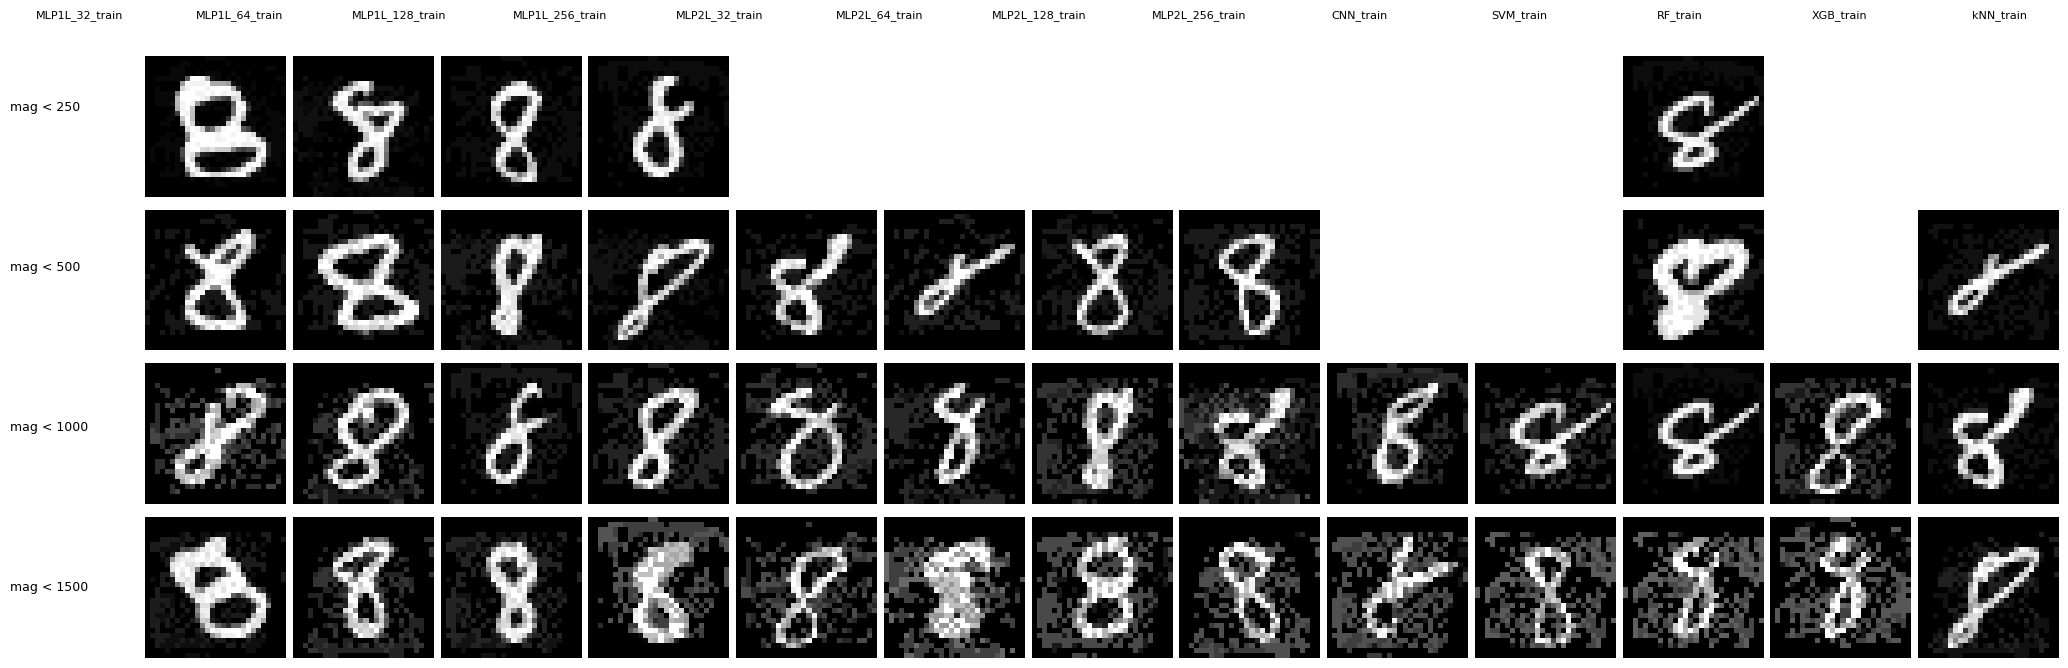

In [31]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import re

# ——— CONFIG ———
digit_to_display = '8'
max_mag_values = [250, 500, 1000, 1500]

folder_paths = [ 
    r"adversarial_8bit_images\MLP1L_32_train",
    r"adversarial_8bit_images\MLP1L_64_train",
    r"adversarial_8bit_images\MLP1L_128_train",
    r"adversarial_8bit_images\MLP1L_256_train",
    r"adversarial_8bit_images\MLP2L_32_train",
    r"adversarial_8bit_images\MLP2L_64_train",
    r"adversarial_8bit_images\MLP2L_128_train",
    r"adversarial_8bit_images\MLP2L_256_train",
    r"adversarial_8bit_images\CNN_train",
    r"adversarial_8bit_images\SVM_train",
    r"adversarial_8bit_images\RF_train",
    r"adversarial_8bit_images\XGB_train",
    r"adversarial_8bit_images\kNN_train"
]

folder_labels = [os.path.basename(p) for p in folder_paths]

digit_pattern = re.compile(r'true(\d)')
mag_pattern = re.compile(r'mag([0-9.]+)')

# Preload all matching images with digit 8
image_data = {label: [] for label in folder_labels}
for folder_path, label in zip(folder_paths, folder_labels):
    for fname in os.listdir(folder_path):
        if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
            m_digit = digit_pattern.search(fname)
            m_mag = mag_pattern.search(fname)
            if m_digit and m_mag and m_digit.group(1) == digit_to_display:
                try:
                    mag_val = float(m_mag.group(1))
                    image_data[label].append((mag_val, os.path.join(folder_path, fname)))
                except ValueError:
                    continue

# ——— PLOTTING: rows = mag thresholds, cols = models ———
n_rows = len(max_mag_values)
n_cols = len(folder_labels)
fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(n_cols * 1.6, n_rows * 1.6),
    squeeze=False
)

for i, max_mag in enumerate(max_mag_values):
    for j, label in enumerate(folder_labels):
        ax = axes[i][j]
        # Filter by current max_mag and pick a random one
        eligible = [path for mag, path in image_data[label] if mag < max_mag]
        if eligible:
            img = mpimg.imread(random.choice(eligible))
            ax.imshow(img, cmap='gray')
        ax.axis('off')

# Label rows with mag values
for i, max_mag in enumerate(max_mag_values):
    y = 1 - (i + 0.5) / n_rows
    fig.text(
        0.005,
        y,
        f'mag < {max_mag}',
        va='center',
        ha='left',
        fontsize=9
    )

# Label columns with model names
for j, label in enumerate(folder_labels):
    x = (j + 0.5) / n_cols
    fig.text(
        x,
        1.01,
        label,
        va='bottom',
        ha='center',
        fontsize=8
    )

plt.subplots_adjust(
    left=0.07,
    right=0.99,
    top=0.96,
    bottom=0.01,
    wspace=0.05,
    hspace=0.05
)

plt.savefig('digit8_under_mag_thresholds.jpg', dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()
